<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club/blob/main/Lending_Club_Loan_Approval_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OVERVIEW**

### **Objective:**
This notebook demonstrates the end-to-end process of building a **Loan Approval Model** for Lending Club to predict whether a loan application would be approved based on borrower profile features.


### **Business Context:**
Lending Club receives a high volume of applications. A predictive model helps **streamline pre-screening**, **reduce manual review workload**, and **minimize missed opportunities** for qualified borrowers.

### **Techniques & Tools**:
* **Logistic Regression** for modeling technique
* **PySpark & Python** (Pandas, scikit-learn, Matplotlib, Seaborn) for data processing, feature engineering, and evaluations.

##### **Author:**  Nhat Linh Tran





# **A. NOTEBOOK SETUP**

In [39]:
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')

Data source import complete.


In [40]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [41]:
!pip install PySpark

In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys

print('Import Libraries')

Import Libraries


In [43]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [44]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# **B. BUILD DATASET**

#### **Metrics**:
* **loan_amnt**: loan amount
* **emp_length**: employment length
* **dti**: debt-to-income ratio
* **accepted_flag**: 1 (approved application), 0 (rejected application)

In [45]:
# Accpeted
accepted_c = accepted_df.withColumn('accepted_flag', lit(1)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'accepted_flag')

# Rejected
rejected_c = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                         .withColumnRenamed('Employment Length', 'emp_length') \
                         .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                         .withColumn('accepted_flag', lit(0)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'accepted_flag')

In [46]:
# Combine 2 datsets
combined_df = accepted_c.union(rejected_c)

combined_df = combined_df.withColumn('emp_length_years',
                                      when(col('emp_length') == '< 1 year', 0)
                                      .when(col('emp_length') == '1 year', 1)
                                      .when(col('emp_length') == '2 years', 2)
                                      .when(col('emp_length') == '3 years', 3)
                                      .when(col('emp_length') == '4 years', 4)
                                      .when(col('emp_length') == '5 years', 5)
                                      .when(col('emp_length') == '6 years', 6)
                                      .when(col('emp_length') == '7 years', 7)
                                      .when(col('emp_length') == '8 years', 8)
                                      .when(col('emp_length') == '9 years', 9)
                                      .when(col('emp_length') == '10+ years', 10)
                                      .when(col('emp_length').isNull(), -1)
                                      .otherwise(-1)) \
                          .filter((col('dti') >= 0) & (col('dti') <= 100))

combined_df = combined_df.drop('emp_length')

In [47]:
combined_df.groupBy('accepted_flag').count().toPandas()

,accepted_flag,count
0,1,2256394
1,0,25637707


# **C. BUILD LOAN APPROVAL MODEL**

## **1. Assemble Features**

* features: contains a single vector of all features per row
* label: the outcome trying to predict

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["loan_amnt", "dti", "emp_length_years"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

## **2. Train Logistic Regression Model**

In [ ]:
# Split into Train and Test Set (80:20)
train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.classification import LogisticRegression

# Transform both sets so they contain 'features'
train_assembled = assembler.transform(train_df)
test_assembled = assembler.transform(test_df)

# Train the model
lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")
model = lr.fit(train_assembled)

## **3. Evaluations**

### **a. Classification Report & Confusion Matrix**

              precision    recall  f1-score   support

    Rejected       0.95      0.98      0.96   5127930
    Accepted       0.65      0.38      0.48    451441

    accuracy                           0.93   5579371
   macro avg       0.80      0.68      0.72   5579371
weighted avg       0.92      0.93      0.93   5579371



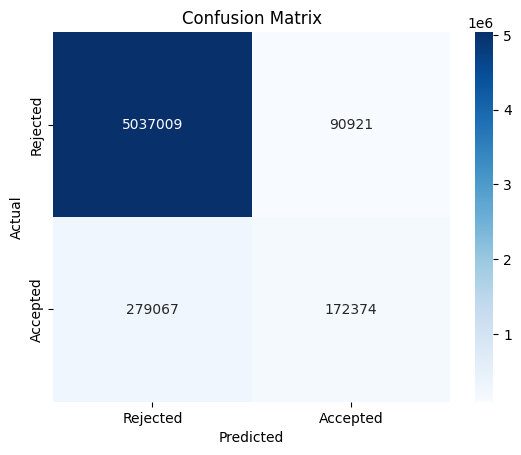

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert prediction results
predictions = model.transform(test_assembled)
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### **b. AUC**

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

AUC: 0.8644822196857993


## **4. Feature Importance**

In [ ]:
coeffs = model.coefficients.toArray()
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,0.416405,0.416405
1,dti,-0.017949,0.017949
0,loan_amnt,0.000019,0.000019


### **a. Observations**:
* **emp_length_years:**

  * The most influential and positively associated with approval
  * The longer of employment, the higher the approval likelihood

* **dti:**
  * Minor negative influence
  * The higher the DTI, the lower probability of being approved

* **loan_amnt**
  * Almost zero impact

### **b. Diagnosing Feature Distribution Issues**

#### **b1. dti (Debt-to-Income Ratio):**
* The majority DTI fall between 0-40, with very few DTI above 40
* The model doesn’t have enough exposure to very high DTI examples to learn how extreme debt burdens affect loan approval decisions
* Weak learning signal leads to small coefficient

In [9]:
# DTI summary statistics

combined_df.select("dti").summary().toPandas()

,summary,dti
0,count,27894101
1,mean,25.930588497524862
2,stddev,23.81351897625889
3,min,0.0
4,25%,9.69
5,50%,19.98
6,75%,34.19
7,max,100.0


In [11]:
# DTI Bucket Distribution

from pyspark.sql.functions import round as spark_round

# Create DTI Bucket
bucket = combined_df.withColumn(
    "dti_bucket",
    when((col("dti") >= 0) & (col("dti") < 10), "0–10")
    .when((col("dti") >= 10) & (col("dti") < 20), "10–20")
    .when((col("dti") >= 20) & (col("dti") < 30), "20–30")
    .when((col("dti") >= 30) & (col("dti") < 40), "30–40")
    .when((col("dti") >= 40) & (col("dti") < 50), "40–50")
    .when((col("dti") >= 50) & (col("dti") < 60), "50–60")
    .when((col("dti") >= 60) & (col("dti") < 70), "60–70")
    .when((col("dti") >= 70) & (col("dti") < 80), "70–80")
    .when((col("dti") >= 80) & (col("dti") < 90), "80–90")
    .when((col("dti") >= 90) & (col("dti") <= 100), "90–100")
)

# Count each Bucket
bucket_counts = bucket.groupBy("dti_bucket").agg(count("*").alias("Loan Counts"))

# Count each Bucket by Accepted Flag
flag_counts = bucket.groupBy("dti_bucket", "accepted_flag").agg(count("accepted_flag").alias("Flag Counts"))

# Total
total_count = combined_df.count()

# Percentage of each Bucket
bucket_df = bucket_counts.join(flag_counts, "dti_bucket") \
                         .withColumn("Bucket/Total", spark_round(col("Loan Counts") / total_count * 100, 2)) \
                         .withColumn("Flag/Bucket", spark_round(col("Flag Counts") / col("Loan Counts") * 100, 2)) \
                         .orderBy("dti_bucket") \
                         .select("dti_bucket", "Loan Counts", "Bucket/Total", "accepted_flag", "Flag Counts", "Flag/Bucket") \
                         .toPandas()
bucket_df

,dti_bucket,Loan Counts,Bucket/Total,accepted_flag,Flag Counts,Flag/Bucket
0,0–10,7167718,25.70,1,407848,5.69
1,0–10,7167718,25.70,0,6759870,94.31
2,10–20,6789357,24.34,1,922306,13.58
3,10–20,6789357,24.34,0,5867051,86.42
4,20–30,5350496,19.18,1,682770,12.76
5,20–30,5350496,19.18,0,4667726,87.24
6,30–40,3377500,12.11,1,218834,6.48
7,30–40,3377500,12.11,0,3158666,93.52
8,40–50,1968261,7.06,1,13446,0.68
9,40–50,1968261,7.06,0,1954815,99.32


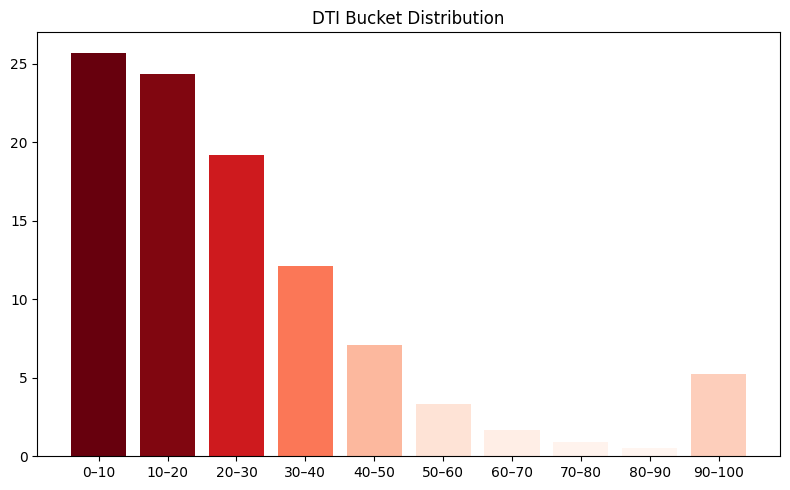

In [31]:
# DTI Bucket Distribution

import matplotlib.colors as mcolors

filtered_df = bucket_df[bucket_df['accepted_flag'] == 1]

x = filtered_df['dti_bucket'].to_numpy()
y = filtered_df['Bucket/Total'].to_numpy()

# Normalize colors based on y-values (Bucket/Total)
norm = mcolors.Normalize(vmin=np.min(y), vmax=np.max(y))
cmap = plt.cm.Reds
colors = cmap(norm(y))

plt.figure(figsize=(8, 5))
bars = plt.bar(x, y, color=colors)
plt.title('DTI Bucket Distribution')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

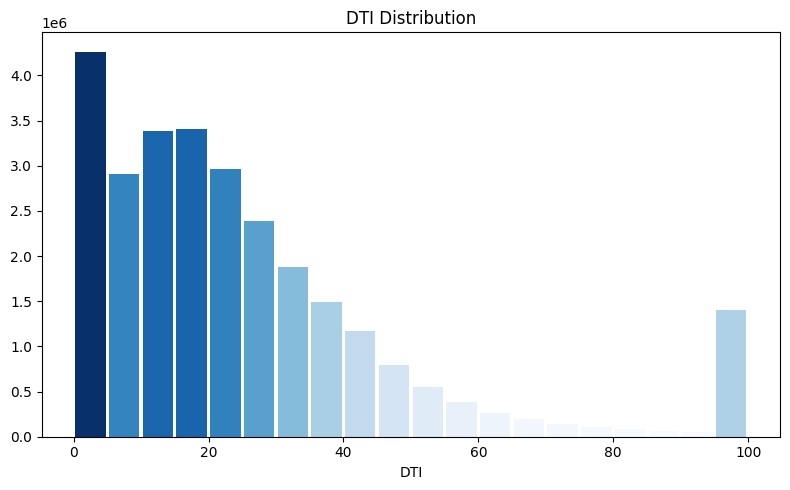

In [49]:
# DTI Distribution

# Define custom bin ranges for DTI (0 to 100 in steps of 5)
dti_hist = combined_df.select("dti").rdd.flatMap(lambda x: x).histogram([i for i in range(0, 105, 5)])

dti_bins = dti_hist[0]
dti_counts = dti_hist[1]

dti_midpoints = [(dti_bins[i] + dti_bins[i+1]) / 2 for i in range(len(dti_bins) - 1)]

import pandas as pd
dti_df_hist = pd.DataFrame({
    "DTI": dti_midpoints,
    "Loan Count": dti_counts
})

x = dti_df_hist['DTI']
y = dti_df_hist['Loan Count']
norm = mcolors.Normalize(vmin=np.min(y), vmax=np.max(y))
cmap = plt.cm.Blues
colors = cmap(norm(y))

plt.figure(figsize=(8, 5))
bars = plt.bar(x, y, width=4.5, color=colors)
plt.title('DTI Distribution')
plt.xlabel('DTI')
plt.ylabel('')
plt.tight_layout()
plt.show()

#### **b2. loan_amnt:**

* Loan amounts range from 0-1.4M, causing a huge scale difference compared to other features
* The model is forced to shrink the coefficient for loan_amnt to avoid overpowering the formula

In [34]:
# loan_amnt summary statistic

combined_df.select("loan_amnt").summary().toPandas()

,summary,loan_amnt
0,count,27894101
1,mean,12640.876970841971
2,stddev,10569.365857912691
3,min,0.0
4,25%,5000.0
5,50%,10000.0
6,75%,20000.0
7,max,1400000.0


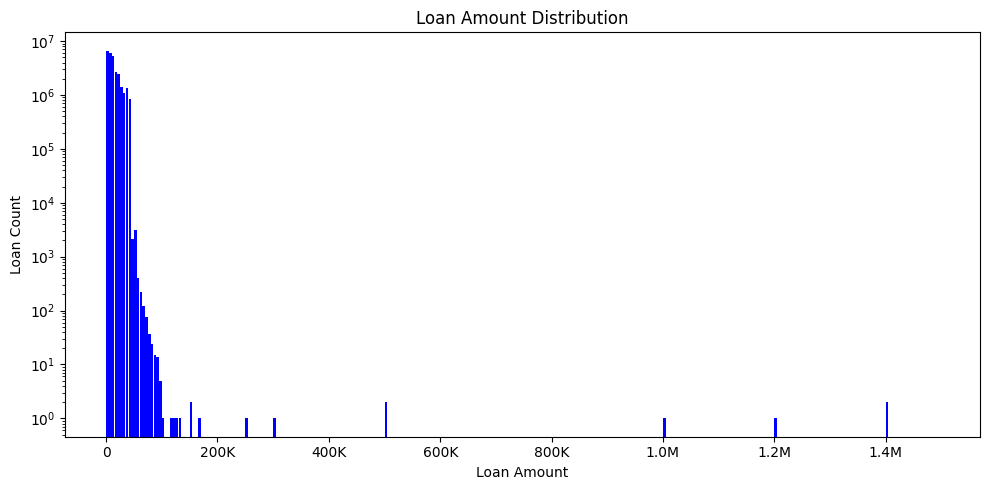

In [37]:
# loan_amnt distribution

from matplotlib.ticker import FuncFormatter

# histogram
hist = combined_df.select("loan_amnt").rdd.flatMap(lambda x: x).histogram([i for i in range(0, 1500000, 5000)])

bins = hist[0]
counts = hist[1]

# Create mid-points for bar chart x-axis
mid_points = [(bins[i] + bins[i+1]) // 2 for i in range(len(bins)-1)]

df_hist = pd.DataFrame({
    "Loan Amount": mid_points,
    "Loan Count": counts
})

x = df_hist['Loan Amount']
y = df_hist['Loan Count']

plt.figure(figsize=(10, 5))
plt.bar(x, y, width=4500, color='blue')
plt.title('Loan Amount Distribution')
plt.yscale('log')

# Custom x-axis tick formatter: Convert to millions with 'M' suffix
def millions_formatter(x_val, pos):
    if x_val >= 1e6:
        return f'{x_val/1e6:.1f}M'
    elif x_val >= 1e3:
        return f'{x_val/1e3:.0f}K'
    else:
        return f'{int(x_val)}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.xticks(rotation=0)
plt.xlabel('Loan Amount')
plt.ylabel('Loan Count')
plt.tight_layout()
plt.show()

# **D. IMPROVED MODEL: Feature Engineering & Retraining:**
#### **Problem:**

  * The initial model showed **weak feature importance**, especially for **'dti'** and **'loan_amnt'**
  
  This happened because of **skewed feature distributions** and **extreme scale differences**
  * The dataset is imbalanced, with rejected = 10x approved



#### **Solutions:**
  * **Winsorization**: cap outliers
  * **MinMax Scaling**: normalize feature ranges
  * **Inverse Class Frequency**: address class imbalance

## **1. Feature Engineering**
* Cap **'dti'** at 50
* Cap **'loan_amnt'** at 42,500
* Add **'class_weight'** to positive class
* Apply **MinMax Scaler**

In [ ]:
# Cap outliers + Add 'calss_weight'

recapped_df = combined_df.withColumn("dti_recapped", when(col("dti") > 50, 50).otherwise(col("dti"))) \
                         .withColumn("loan_amnt_recapped", when(col("loan_amnt") > 42500, 42500).otherwise(col("loan_amnt"))) \
                         .withColumn("class_weight", when(col('accepted_flag') == 1, 12.26).otherwise(1.0))

In [ ]:
# Split data

retrain_df, retest_df = recapped_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Assemble capped features

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["loan_amnt_recapped", "dti_recapped", "emp_length_years"], outputCol="raw_features")
reassembled = assembler.transform(recapped_df)
reassembled.select("loan_amnt_recapped", "dti_recapped", "emp_length_years", "raw_features").show(5, truncate=False)

+------------------+------------+----------------+--------------------+
|loan_amnt_recapped|dti_recapped|emp_length_years|raw_features        |
+------------------+------------+----------------+--------------------+
|3600.0            |5.91        |10              |[3600.0,5.91,10.0]  |
|24700.0           |16.06       |10              |[24700.0,16.06,10.0]|
|20000.0           |10.78       |10              |[20000.0,10.78,10.0]|
|35000.0           |17.06       |10              |[35000.0,17.06,10.0]|
|10400.0           |25.37       |3               |[10400.0,25.37,3.0] |
+------------------+------------+----------------+--------------------+
only showing top 5 rows



In [ ]:
# Fit MinMax Scaler on 'raw_features'

from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")
scaler_model = scaler.fit(reassembled)
scaled_df = scaler_model.transform(reassembled)
scaled_df.select("loan_amnt_recapped", "dti_recapped", "emp_length_years", "features").show(5, truncate=False)

+------------------+------------+----------------+-----------------------------------------------------------+
|loan_amnt_recapped|dti_recapped|emp_length_years|features                                                   |
+------------------+------------+----------------+-----------------------------------------------------------+
|3600.0            |5.91        |10              |[0.08470588235294119,0.1182,1.0]                           |
|24700.0           |16.06       |10              |[0.5811764705882353,0.3212,1.0]                            |
|20000.0           |10.78       |10              |[0.4705882352941177,0.21559999999999999,1.0]               |
|35000.0           |17.06       |10              |[0.823529411764706,0.3412,1.0]                             |
|10400.0           |25.37       |3               |[0.2447058823529412,0.5074000000000001,0.36363636363636365]|
+------------------+------------+----------------+-----------------------------------------------------------+
o

## **2. Train Logistic Regression Model**

In [ ]:
# Train model

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Model
lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(retrain_df)

## **3. Evaluations**

              precision    recall  f1-score   support

    Rejected       0.97      0.88      0.93   5127930
    Accepted       0.35      0.73      0.47    451441

    accuracy                           0.87   5579371
   macro avg       0.66      0.80      0.70   5579371
weighted avg       0.92      0.87      0.89   5579371



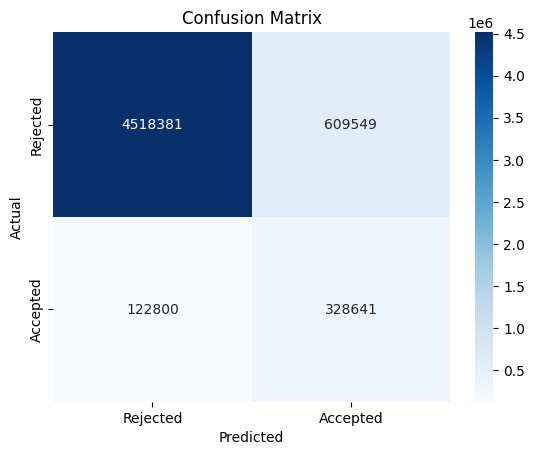

AUC: 0.8620388091895714


In [ ]:
# Predictions & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model.transform(retest_df)
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

## **4. Feature Importance**

In [ ]:
feature_cols = ["loan_amnt_capped", "dti_capped", "emp_length_years"]

lr_model = model.stages[-1]

coeffs = lr_model.coefficients.toArray()

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,4.600914,4.600914
1,dti_capped,-0.821242,0.821242
0,loan_amnt_capped,0.784724,0.784724


### **Observations**
* **emp_length_years**
  * Remains the strongest impact

* **dti**
  * Stronger negative influence compared to before
  * The model can better recognize how higher DTI lowers approval chances after capping and scaling

* **loan_amnt**
  * Now has a meaningful positive coefficient
  * The model suggests the positive relationship between loan amount and acceptance likelihood.
